# **1. Data Preprocessing**

## **Import Package and Load Dataset**

In [1]:
import numpy as np
import pandas as pd
import re
import unicodedata
from multiprocessing import Pool, cpu_count
from tqdm import tqdm
import nltk
import emoji
from functools import partial
import matplotlib.pyplot as plt
import seaborn as sns
import gdown

import spacy
from spacy.symbols import ORTH
from spacy.lang.en.stop_words import STOP_WORDS

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Embedding, LSTM, Dropout, Dense, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping

from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier

from transformers import LongformerTokenizerFast, LongformerForSequenceClassification
from transformers import Trainer, TrainingArguments
from transformers import get_linear_schedule_with_warmup

import torch
import datasets
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
import torch.distributed as dist
import torch.multiprocessing as mp

nlp = spacy.load('en_core_web_sm')

2025-06-17 11:35:30.889187: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750160131.119394      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750160131.185662      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
fake_news = pd.read_csv('/kaggle/input/true-fake-news-datasets/DataSet_Misinfo_FAKE.csv').drop('Unnamed: 0', axis=1)
true_news = pd.read_csv('/kaggle/input/true-fake-news-datasets/DataSet_Misinfo_TRUE.csv').drop('Unnamed: 0', axis=1)

In [ ]:
fake_news.head()

,text
0,Donald Trump just couldn t wish all Americans ...
1,House Intelligence Committee Chairman Devin Nu...
2,"On Friday, it was revealed that former Milwauk..."
3,"On Christmas day, Donald Trump announced that ..."
4,Pope Francis used his annual Christmas Day mes...


In [ ]:
true_news.head()

,text
0,The head of a conservative Republican faction ...
1,Transgender people will be allowed for the fir...
2,The special counsel investigation of links bet...
3,Trump campaign adviser George Papadopoulos tol...
4,President Donald Trump called on the U.S. Post...


In [ ]:
fake_news.shape, true_news.shape

((43642, 1), (34975, 1))

## **Check and Drop Missing Values**

In [ ]:
fake_news['text'].isnull().sum(), true_news['text'].isnull().sum()

(0, 29)

In [ ]:
true_news.dropna(axis=0, inplace=True)

## **Check and Drop Duplicates**

In [ ]:
fake_news.duplicated().sum(), true_news.duplicated().sum()

(9564, 420)

In [ ]:
fake_news.drop_duplicates(inplace=True)
true_news.drop_duplicates(inplace=True)

## **Regex-based Text Processing**

In [ ]:
months_en_full = r"(?:January|February|March|April|May|June|July|August|September|October|November|December)"
months_en_abbr = r"(?:Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec)"
all_months_en = f"(?:{months_en_full}|{months_en_abbr})"
pattern1 = rf'\b(?:{all_months_en})\s+(?:0?[1-9]|[12]\d|3[01]),?\s*(?:19|20)\d{{2}}(?!\d)'
pattern2 = r'\b(?:0?[1-9]|[12]\d|3[01])([/\-.])(?:0?[1-9]|1[0-2])\1(?:19|20)?\d{2}(?!\d)'
pattern3 = r'\b(?:19|20)\d{2}([/\-.])(?:0?[1-9]|1[0-2])\1(?:0?[1-9]|[12]\d|3[01])(?!\d)'

URL_REGEX = re.compile(
    r'\b(?:https?://|ftp://|www\.)\S+[a-zA-Z0-9/]|'
    r'\b([a-zA-Z0-9][a-zA-Z0-9-]{0,61}[a-zA-Z0-9]\.)+'
    r'(?:[a-zA-Z]{2,63})'
    r'(?:[/\?#]\S*)?\b',
    re.IGNORECASE
)
MENTION_REGEX = re.compile(
    r'@\w+',
    re.IGNORECASE
)
HASHTAG_REGEX = re.compile(r'#\w+', re.IGNORECASE)
DATE_REGEX_1 = re.compile(
    pattern1,
    re.IGNORECASE
)
DATE_REGEX_2 = re.compile(
    pattern2,
    re.IGNORECASE
)
DATE_REGEX_3 = re.compile(
    pattern3,
    re.IGNORECASE
)
CHARACTER_REGEX = re.compile(r"[<>()|&©ø\[\]\",;?~*!]") # Keep apostrophe (')

def preprocessing_text(text):
    text = unicodedata.normalize('NFC', text)
    lower_text = text.lower()
    no_tab = re.sub(r'\t', ' ', lower_text)
    no_return = re.sub(r'\r', ' ', no_tab)
    no_newline = re.sub(r'\n', ' ', no_return)
    no_multi_symbols = re.sub(r'[~_\-+\.]{2,}', ' ', no_newline)
    no_symbols = CHARACTER_REGEX.sub(' ', no_multi_symbols)
    no_apostrophe = re.sub(r"(?<!\w)'|'(?!\w)", ' ', no_symbols)

    no_dot_space = re.sub("(\.\s+)", ' ', no_apostrophe)
    no_dash_space = re.sub("(\-\s+)", ' ', no_dot_space)
    no_colon_space = re.sub("(\:\s+)", ' ', no_dash_space)
    no_single_symbols = re.sub(r'\s(?!a\b|i\b)[^\w\s]\s|\s(?!a\b|i\b)\w\b', ' ', no_colon_space)

    replace_url = URL_REGEX.sub(' __url__ ', no_single_symbols)
    replace_mention = MENTION_REGEX.sub(' __mention__ ', replace_url)
    replace_hashtag = HASHTAG_REGEX.sub(' __tag__ ', replace_mention)
    replace_date = DATE_REGEX_1.sub(' __date__ ', replace_hashtag)
    replace_date = DATE_REGEX_2.sub(' __date__ ', replace_date)
    replace_date = DATE_REGEX_3.sub(' __date__ ', replace_date)
    distinct_emojis = emoji.distinct_emoji_list(replace_date)
    if distinct_emojis:
        sorted_emojis = sorted(distinct_emojis, key=len, reverse=True)
        escaped_emojis = [re.escape(e) for e in sorted_emojis]
        emoji_pattern = re.compile("|".join(escaped_emojis))
        result_text = emoji_pattern.sub(' __emoji__ ', replace_date)
    else:
        result_text = replace_date
    result_text = " ".join(result_text.split())
    return result_text

In [ ]:
# Đếm số lượng cpu sẵn có để dùng multiprocessing
num_cores = cpu_count() - 1 if cpu_count() > 1 else 1
num_cores

3

In [ ]:
# Tiền xử lý văn bản (regex)
with Pool(processes=num_cores) as pool:
    chunk_size = max(1, len(fake_news) // (num_cores * 4))
    processed_fake_texts = list(tqdm(pool.imap(preprocessing_text, fake_news['text'].tolist(), chunksize=chunk_size),
                        total=len(fake_news),
                        desc="Đang tiền xử lý văn bản fake news"))
    chunk_size = max(1, len(true_news) // (num_cores * 4))
    processed_true_texts = list(tqdm(pool.imap(preprocessing_text, true_news['text'].tolist(), chunksize=chunk_size),
                        total=len(true_news),
                        desc="Đang tiền xử lý văn bản true news"))

fake_df = pd.DataFrame(processed_fake_texts, columns=['processed_text'])
true_df = pd.DataFrame(processed_true_texts, columns=['processed_text'])
fake_df['label'] = 1
true_df['label'] = 0

Đang tiền xử lý văn bản true news: 100%|██████████| 34526/34526 [01:12<00:00, 473.20it/s]


## **Lemmatization and Stopwords Removal**

In [ ]:
special_tokens = {"__url__", "__mention__", "__emoji__", "__tag__", "__date__"}
# Thêm token đặc biệt để giữ nguyên khi tokenize
for token in special_tokens:
    nlp.tokenizer.add_special_case(token, [{ORTH: token}])

In [ ]:
important_words = {"not", "no", "never", "very", "only", "just", "most", "few", "many", "some"}
custom_stopwords = STOP_WORDS - important_words

def remove_stopwords_and_lemmatize(texts):
    results = []
    with nlp.select_pipes(disable=["parser", "ner"]):
        for doc in tqdm(nlp.pipe(texts, batch_size=800, n_process=-1), total=len(texts), desc='Đang tokenize'):
            tokens = []
            for token in doc:
                if token.text.lower() in special_tokens:
                    tokens.append(token.text.lower())
                elif not token.is_digit and not token.is_punct and token.lemma_.lower() not in custom_stopwords:
                    tokens.append(token.lemma_.lower())
            results.append(' '.join(tokens))
    return results

In [ ]:
fake_df["clean_text"] = remove_stopwords_and_lemmatize(fake_df["processed_text"])

Đang tokenize: 100%|██████████| 34078/34078 [11:41<00:00, 48.59it/s]  


In [ ]:
true_df["clean_text"] = remove_stopwords_and_lemmatize(true_df["processed_text"])

Đang tokenize: 100%|██████████| 34526/34526 [14:14<00:00, 40.41it/s]  


In [ ]:
fake_df = fake_df[fake_df['clean_text'] != '']
true_df = true_df[true_df['clean_text'] != '']

In [ ]:
# Xuất df ra file csv
try:
    fake_df.to_csv("fake_df.csv", index=False, encoding='utf-8-sig')
    print("\nĐã xuất DataFrame đã xử lý ra file CSV: fake_df.csv")
    print(fake_df.head())
    true_df.to_csv("true_df.csv", index=False, encoding='utf-8-sig')
    print("\nĐã xuất DataFrame đã xử lý ra file CSV: true_df.csv")
    print(true_df.head())
except Exception as e:
    print(f"Lỗi khi xuất CSV: {e}")


Đã xuất DataFrame đã xử lý ra file CSV: fake_df.csv
                                      processed_text  label  \
0  donald trump just couldn wish all americans a ...      1   
1  house intelligence committee chairman devin nu...      1   
2  on friday it was revealed that former milwauke...      1   
3  on christmas day donald trump announced that h...      1   
4  pope francis used his annual christmas day mes...      1   

                                          clean_text  
0  donald trump just couldn wish americans happy ...  
1  house intelligence committee chairman devin nu...  
2  friday reveal milwaukee sheriff david clarke c...  
3  christmas day donald trump announce work follo...  
4  pope francis use annual christmas day message ...  

Đã xuất DataFrame đã xử lý ra file CSV: true_df.csv
                                      processed_text  label  \
0  the head of a conservative republican faction ...      0   
1  transgender people will be allowed for the fir...      0

In [2]:
!gdown 1HQi_WW08joXI5ZZLd1CtrwVRLmL0UCgj
!gdown 1NWYyoM7VngE3sBQRRK1oS-AA3MB1r8Jl
fake_df = pd.read_csv("fake_df_1.csv")
true_df = pd.read_csv("true_df_1.csv")

Downloading...
From (original): https://drive.google.com/uc?id=1HQi_WW08joXI5ZZLd1CtrwVRLmL0UCgj
From (redirected): https://drive.google.com/uc?id=1HQi_WW08joXI5ZZLd1CtrwVRLmL0UCgj&confirm=t&uuid=6ac8ae0f-126c-4f10-8bdd-a61528964d11
To: /kaggle/working/fake_df_1.csv
100%|█████████████████████████████████████████| 139M/139M [00:01<00:00, 123MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1NWYyoM7VngE3sBQRRK1oS-AA3MB1r8Jl
From (redirected): https://drive.google.com/uc?id=1NWYyoM7VngE3sBQRRK1oS-AA3MB1r8Jl&confirm=t&uuid=267cadbc-d042-42b9-8e59-6f7d19a16cb9
To: /kaggle/working/true_df_1.csv
100%|█████████████████████████████████████████| 179M/179M [00:01<00:00, 112MB/s]


# **2. Exploratory Data Analysis (EDA)**

## **Data Summary**

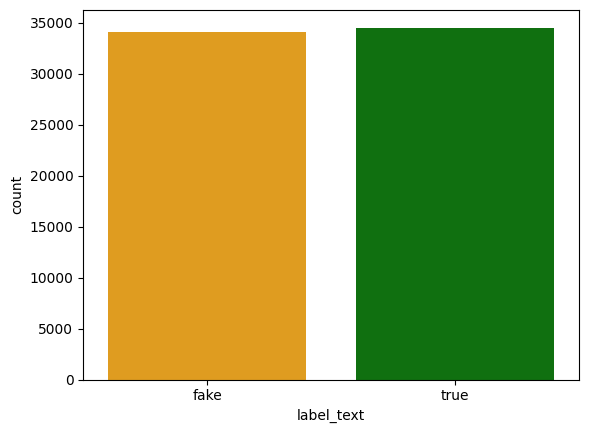

In [3]:
df_concat = pd.concat([fake_df, true_df], axis=0).reset_index(drop=True)
df_concat['label_text'] = df_concat['label'].map({0: 'true', 1: 'fake'})
sns.countplot(x=df_concat['label_text'], palette=['orange', 'green'])
plt.legend().set_visible(False)
plt.show()

In [ ]:
length = len(df_concat)
percent_real = len(df_concat[df_concat['label']==0])/length*100
percent_fake = len(df_concat[df_concat['label']==1])/length*100
print(f'There are {length} articles. \n{percent_real:.2f}% are real articles and {percent_fake:.2f}% are fake articles.')

There are 68604 articles. 
50.33% are real articles and 49.67% are fake articles.


## **Special Tokens Analysis**

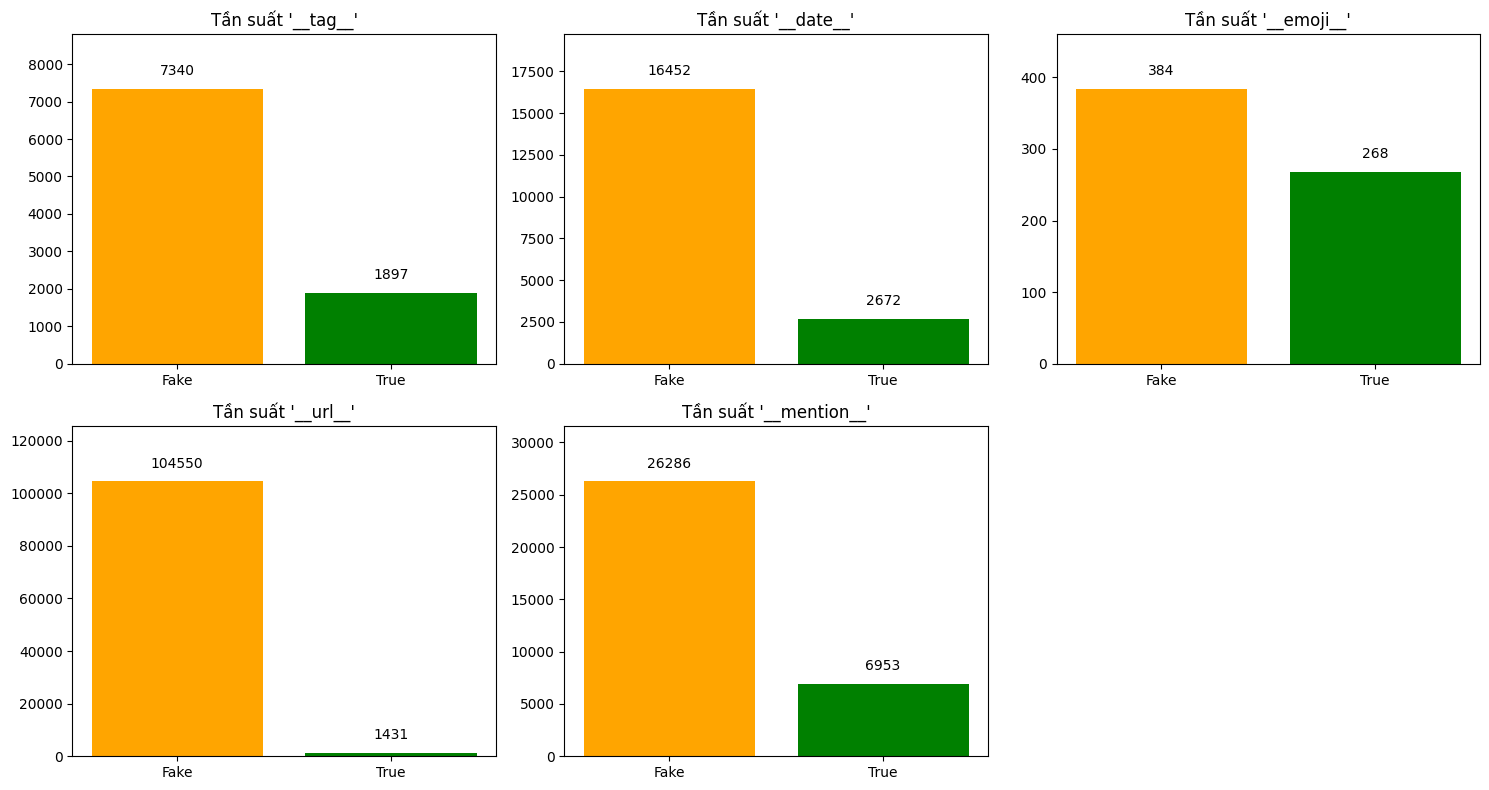

In [ ]:
def count_pattern(pattern, texts):
    freq = []
    for row in texts:
        matches = re.findall(pattern, row, flags=re.IGNORECASE)
        freq.append(len(matches))
    return freq
num_special_tokens_fake_df = {}
num_special_tokens_true_df = {}
for tok in special_tokens:
    num_special_tokens_fake_df[tok] = count_pattern(tok, fake_df['processed_text'])
    num_special_tokens_true_df[tok] = count_pattern(tok, true_df['processed_text'])

n = len(special_tokens)
cols = 3
rows = (n + cols - 1) // cols

fig = plt.figure(figsize=(cols*5, rows*4))

for i, tok in enumerate(special_tokens):
    ax = fig.add_subplot(rows, cols, i+1)
    fake_val = sum(num_special_tokens_fake_df[tok])
    true_val = sum(num_special_tokens_true_df[tok])
    ax.bar(['Fake', 'True'], [fake_val, true_val], color=['orange', 'green'])
    ax.set_title(f"Tần suất '{tok}'")
    ax.set_ylim(0, max(fake_val, true_val) * 1.2)
    for j, v in enumerate([fake_val, true_val]):
        ax.text(j, v + max(fake_val, true_val)*0.05, str(v), ha='center')
plt.tight_layout()
plt.show()

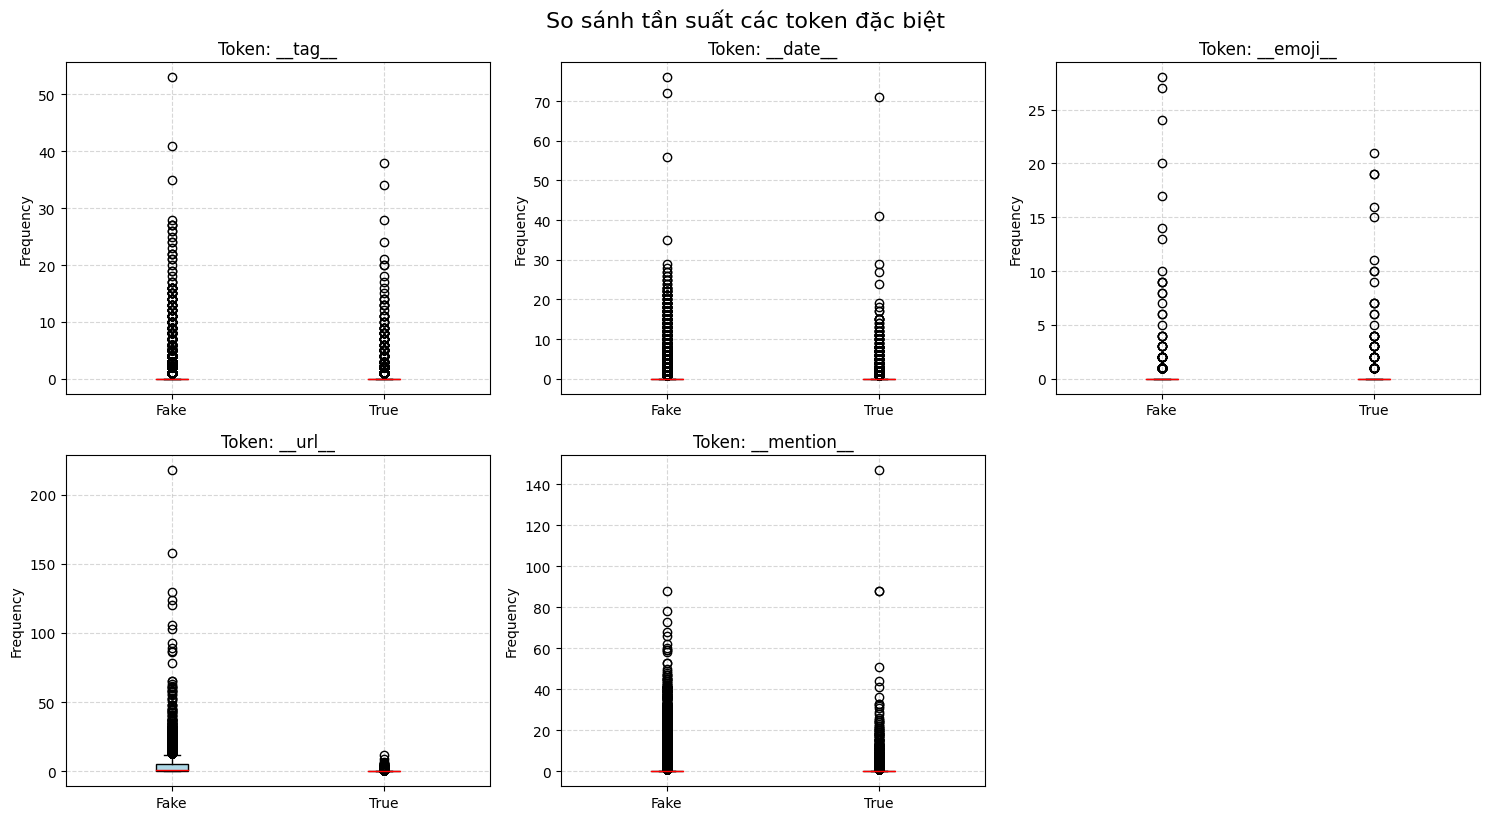

In [ ]:
fig = plt.figure(figsize=(cols * 5, rows * 4))

for i, tok in enumerate(special_tokens):
    ax = fig.add_subplot(rows, cols, i + 1)

    # Lấy danh sách tần suất
    fake_freq = num_special_tokens_fake_df[tok]
    true_freq = num_special_tokens_true_df[tok]

    # Tuỳ chọn: nếu dữ liệu chênh lệch lớn
    # fake_freq = np.log1p(fake_freq)
    # true_freq = np.log1p(true_freq)

    ax.boxplot([fake_freq, true_freq],
               labels=['Fake', 'True'],
               patch_artist=True,
               boxprops=dict(facecolor='lightblue'),
               medianprops=dict(color='red'))

    ax.set_title(f"Token: {tok}")
    ax.set_ylabel("Frequency")
    ax.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.suptitle("So sánh tần suất các token đặc biệt", fontsize=16, y=1.02)
plt.show()

## **Text Length Distribution Analysis**

In [ ]:
def count_words(text):
    words = text.split()
    return len(words)

fake_df['num_words'] = fake_df['processed_text'].apply(count_words)
true_df['num_words'] = true_df['processed_text'].apply(count_words)
fake_df['num_words_clean_text'] = fake_df['clean_text'].apply(count_words)
true_df['num_words_clean_text'] = true_df['clean_text'].apply(count_words)

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

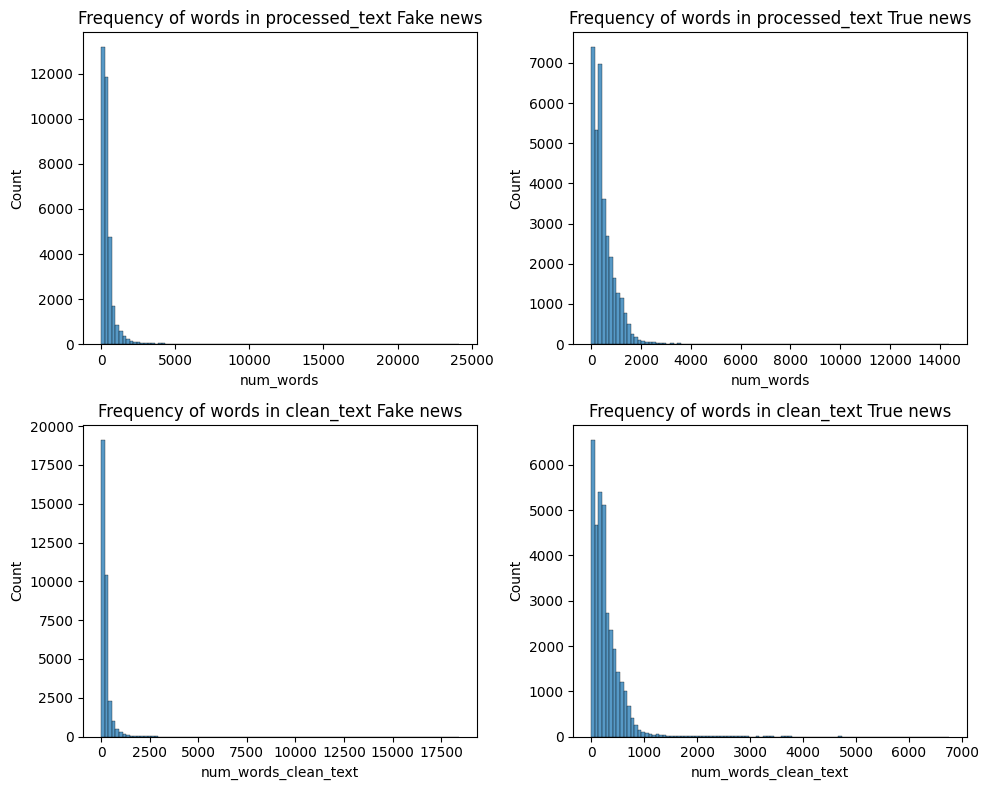

In [ ]:
# Frequency of words
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

sns.histplot(fake_df['num_words'], bins=100, ax=axes[0, 0])
axes[0, 0].set_title('Frequency of words in processed_text Fake news')

sns.histplot(true_df['num_words'], bins=100, ax=axes[0, 1])
axes[0, 1].set_title('Frequency of words in processed_text True news')

sns.histplot(fake_df['num_words_clean_text'], bins=100, ax=axes[1, 0])
axes[1, 0].set_title('Frequency of words in clean_text Fake news')

sns.histplot(true_df['num_words_clean_text'], bins=100, ax=axes[1, 1])
axes[1, 1].set_title('Frequency of words in clean_text True news')

plt.tight_layout()
plt.show()

In [ ]:
# Median/Mean of length of words of clean_text
print(f"Median / Mean of length words fake news: {fake_df['num_words_clean_text'].median()} / {fake_df['num_words_clean_text'].mean():.2f}")
print(f"Median / Mean of length words true news: {true_df['num_words_clean_text'].median()} / {true_df['num_words_clean_text'].mean():.2f}")

Median / Mean of length words fake news: 167.0 / 219.74
Median / Mean of length words true news: 210.0 / 278.18


In [ ]:
# Tìm Outliers cho length of words of clean_text
def find_outliers(num_words):
  Q1 = num_words.quantile(0.25)
  Q3 = num_words.quantile(0.75)
  IQR = Q3 - Q1
  lower_bound = Q1 - 1.5 * IQR
  upper_bound = Q3 + 1.5 * IQR
  outliers = num_words[(num_words < lower_bound) | (num_words > upper_bound)]
  return outliers, lower_bound, upper_bound

fake_outliers, fake_lower_bound, fake_upper_bound = find_outliers(fake_df['num_words_clean_text'])
true_outliers, true_lower_bound, true_upper_bound = find_outliers(true_df['num_words_clean_text'])

print(f"Lower/Upper bound of length of words Fake news: {fake_lower_bound} / {fake_upper_bound}")
print(f"Lower/Upper bound of length of words True news: {true_lower_bound} / {true_upper_bound}")
print(f"% Outlier length of words Fake news: {fake_outliers.shape[0]/fake_df.shape[0]*100:.2f}%")
print(f"% Outlier length of words True news: {true_outliers.shape[0]/true_df.shape[0]*100:.2f}%")

Lower/Upper bound of length of words Fake news: -262.5 / 573.5
Lower/Upper bound of length of words True news: -320.5 / 795.5
% Outlier length of words Fake news: 6.24%
% Outlier length of words True news: 3.27%


In [ ]:
# Calculate quantile 90, 95. 98 and 99
quantiles = [0.90, 0.95, 0.98, 0.99]
p_fake = {}
p_true = {}
for q in quantiles:
    p_fake[q] = round(fake_df['num_words_clean_text'].quantile(q))
    p_true[q] = round(true_df['num_words_clean_text'].quantile(q))

quantiles_df = pd.DataFrame({
    'Fake News Length': p_fake,
    'True News Length': p_true
})

quantiles_df.index = [f'{int(q*100)}%' for q in quantiles_df.index]
quantiles_df.index.name = "Quantile"
quantiles_df

,Fake News Length,True News Length
Quantile,,
90%,437,591
95%,647,714
98%,1003,915
99%,1354,1228


In [4]:
# Calculating vocabulary coverage of the Corpus
def compute_coverage(freqs, coverage_percent=0.9):
    total_count = sum(freqs)
    freqs = sorted(freqs, reverse=True)
    cumulative = 0
    num_words = 0
    for count in freqs:
        cumulative += count
        num_words += 1
        if cumulative / total_count >= coverage_percent:
            break
    return num_words

default_filters = '!"#$%&()*+,-./:;=?@[\\]^`{|}~\t\n<>'

In [ ]:
tokenizer = Tokenizer(oov_token='<unk>', filters=default_filters)
tokenizer.fit_on_texts(df_concat['clean_text'])
freqs = tokenizer.word_counts.values()

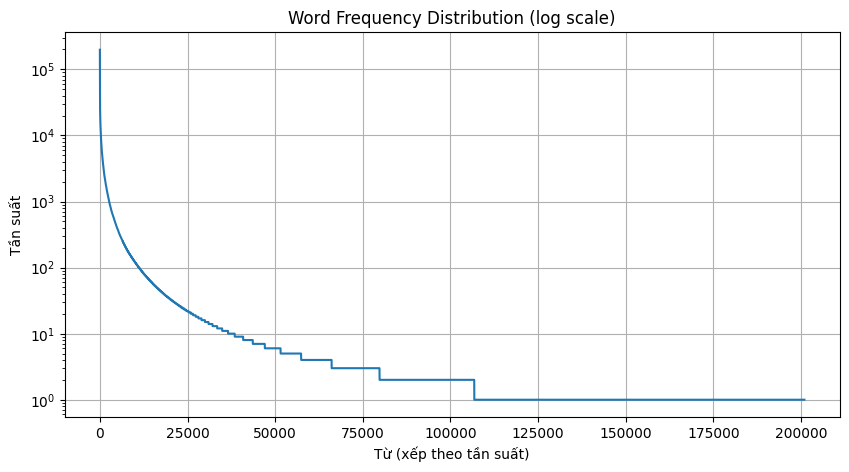

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(sorted(freqs, reverse=True))
plt.yscale('log')
plt.title("Word Frequency Distribution (log scale)")
plt.xlabel("Từ (xếp theo tần suất)")
plt.ylabel("Tần suất")
plt.grid(True)
plt.show()

In [ ]:
print(f"Vocabulary size to cover 90% of corpus: {compute_coverage(freqs, 0.9)}")
print(f"Vocabulary size to cover 95% of corpus: {compute_coverage(freqs, 0.95)}")
print(f"Vocabulary size to cover 98% of corpus: {compute_coverage(freqs, 0.98)}")
print(f"Vocabulary size to cover 99% of corpus: {compute_coverage(freqs, 0.99)}")

Vocabulary size to cover 90% of corpus: 7467
Vocabulary size to cover 95% of corpus: 15787
Vocabulary size to cover 98% of corpus: 39145
Vocabulary size to cover 99% of corpus: 72217


## **WordCloud**

### - True news

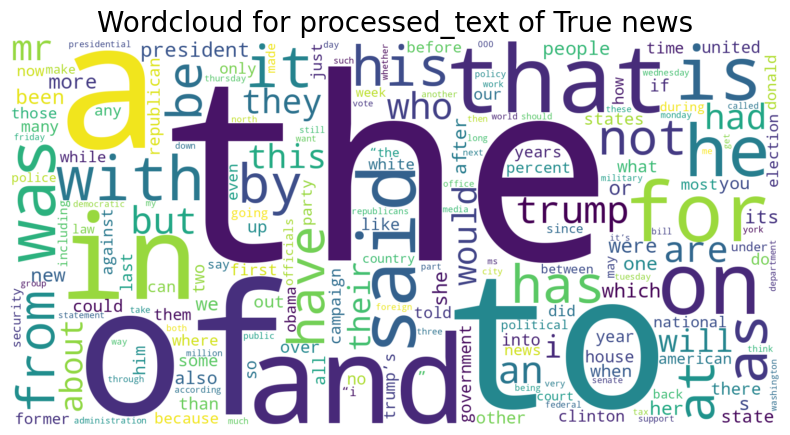

In [ ]:
tokenizer1 = Tokenizer(oov_token='<unk>', filters=default_filters)
tokenizer1.fit_on_texts(true_df['processed_text'])
word_counts = dict(tokenizer1.word_counts)

plt.figure(figsize = (10,5))
wc = WordCloud(width = 1600, height = 800, background_color='white').generate_from_frequencies(word_counts)
plt.imshow(wc, interpolation = 'bilinear')
plt.axis('off')
plt.title('Wordcloud for processed_text of True news', fontsize = 20)
plt.show()

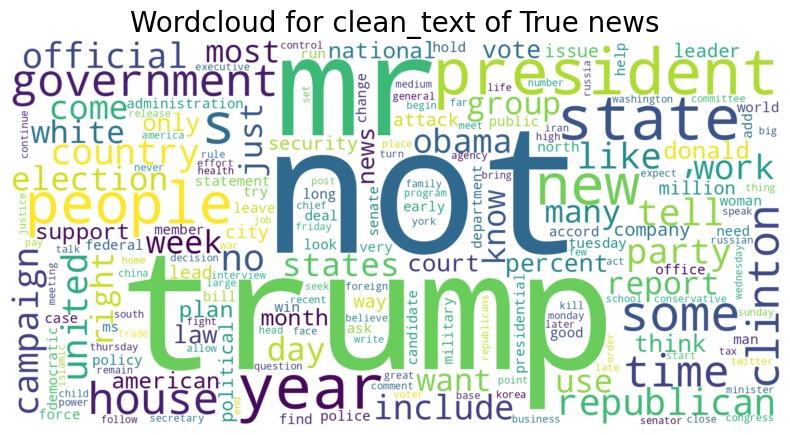

In [ ]:
tokenizer2 = Tokenizer(oov_token='<unk>', filters=default_filters)
tokenizer2.fit_on_texts(true_df['clean_text'])
word_counts = dict(tokenizer2.word_counts)

plt.figure(figsize = (10,5))
wc = WordCloud(width = 1600, height = 800, background_color='white').generate_from_frequencies(word_counts)
plt.imshow(wc, interpolation = 'bilinear')
plt.axis('off')
plt.title('Wordcloud for clean_text of True news', fontsize = 20)
plt.show()

### - Fake news

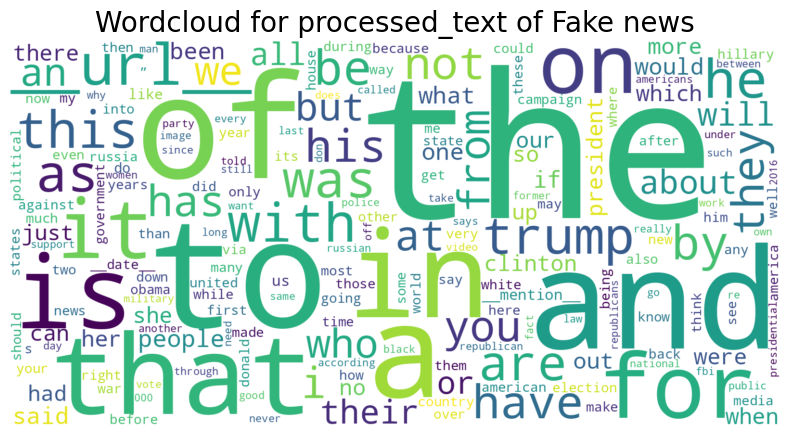

In [ ]:
tokenizer3 = Tokenizer(oov_token='<unk>', filters=default_filters)
tokenizer3.fit_on_texts(fake_df['processed_text'])
word_counts = dict(tokenizer3.word_counts)

plt.figure(figsize = (10,5))
wc = WordCloud(width = 1600, height = 800, background_color='white').generate_from_frequencies(word_counts)
plt.imshow(wc, interpolation = 'bilinear')
plt.axis('off')
plt.title('Wordcloud for processed_text of Fake news', fontsize = 20)
plt.show()

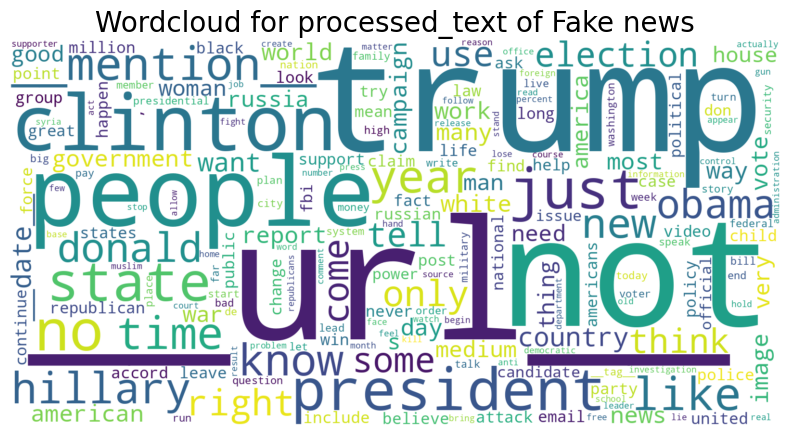

In [ ]:
tokenizer4 = Tokenizer(oov_token='<unk>', filters=default_filters)
tokenizer4.fit_on_texts(fake_df['clean_text'])
word_counts = dict(tokenizer4.word_counts)

plt.figure(figsize = (10,5))
wc = WordCloud(width = 1600, height = 800, background_color='white').generate_from_frequencies(word_counts)
plt.imshow(wc, interpolation = 'bilinear')
plt.axis('off')
plt.title('Wordcloud for processed_text of Fake news', fontsize = 20)
plt.show()

## N-gram Analysis

In [ ]:
def get_top_ngrams(corpus, top_k, ngram, reverse=True):
    vecs = CountVectorizer(ngram_range=(ngram, ngram)).fit(corpus)
    bag_of_words = vecs.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vecs.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=reverse)
    result = words_freq[:top_k]
    return result

### Unigram

In [ ]:
most_common_uni = get_top_ngrams(df_concat['clean_text'], 10, 1)

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


Text(0.5, 1.0, 'Most Common Real Title Unigram')

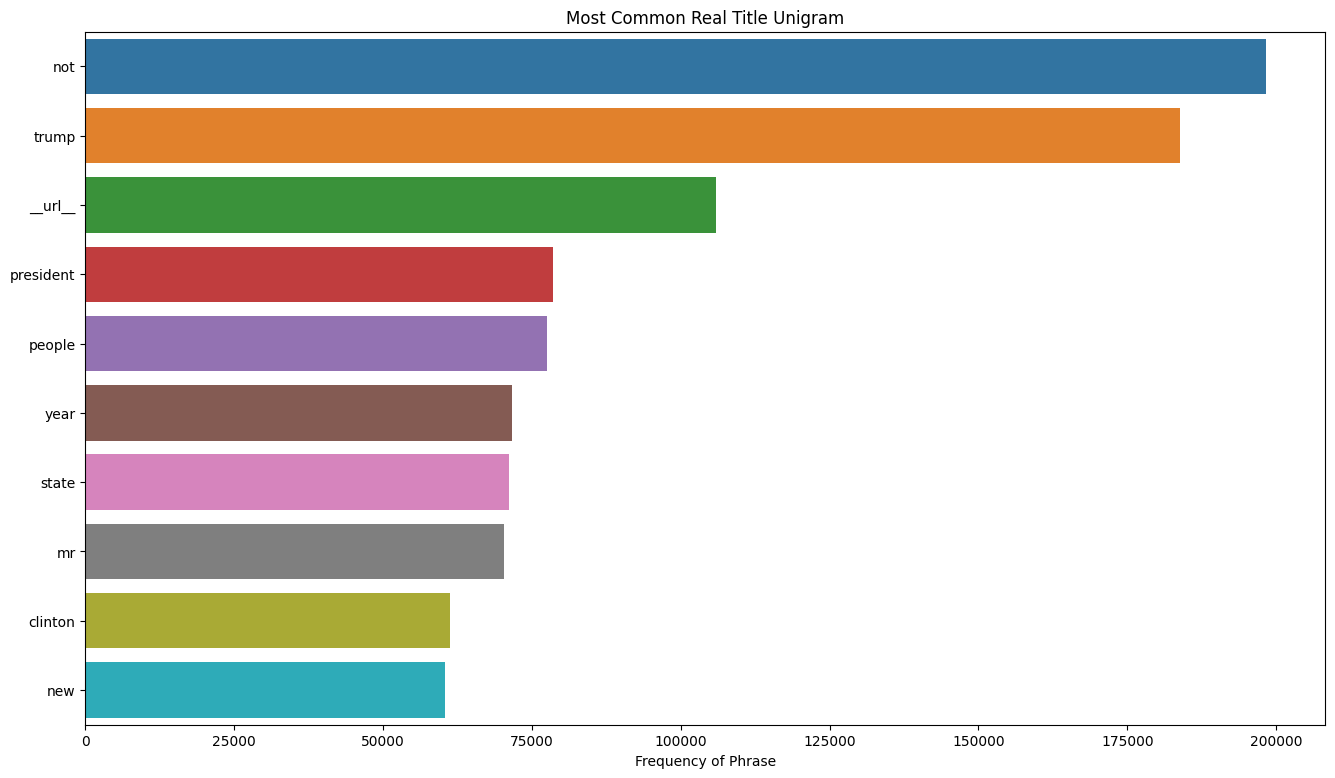

In [ ]:
plt.figure(figsize = (16,9))
most_common_uni = dict(most_common_uni)
sns.barplot(x=list(most_common_uni.values()),y=list(most_common_uni.keys()))
plt.xlabel('Frequency of Phrase')
plt.title('Most Common Unigram In Corpus')

### Bigrams

In [ ]:
most_common_bi = get_top_ngrams(df_concat['clean_text'], 10, 2)

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


Text(0.5, 1.0, 'Most Common Real Title Unigram')

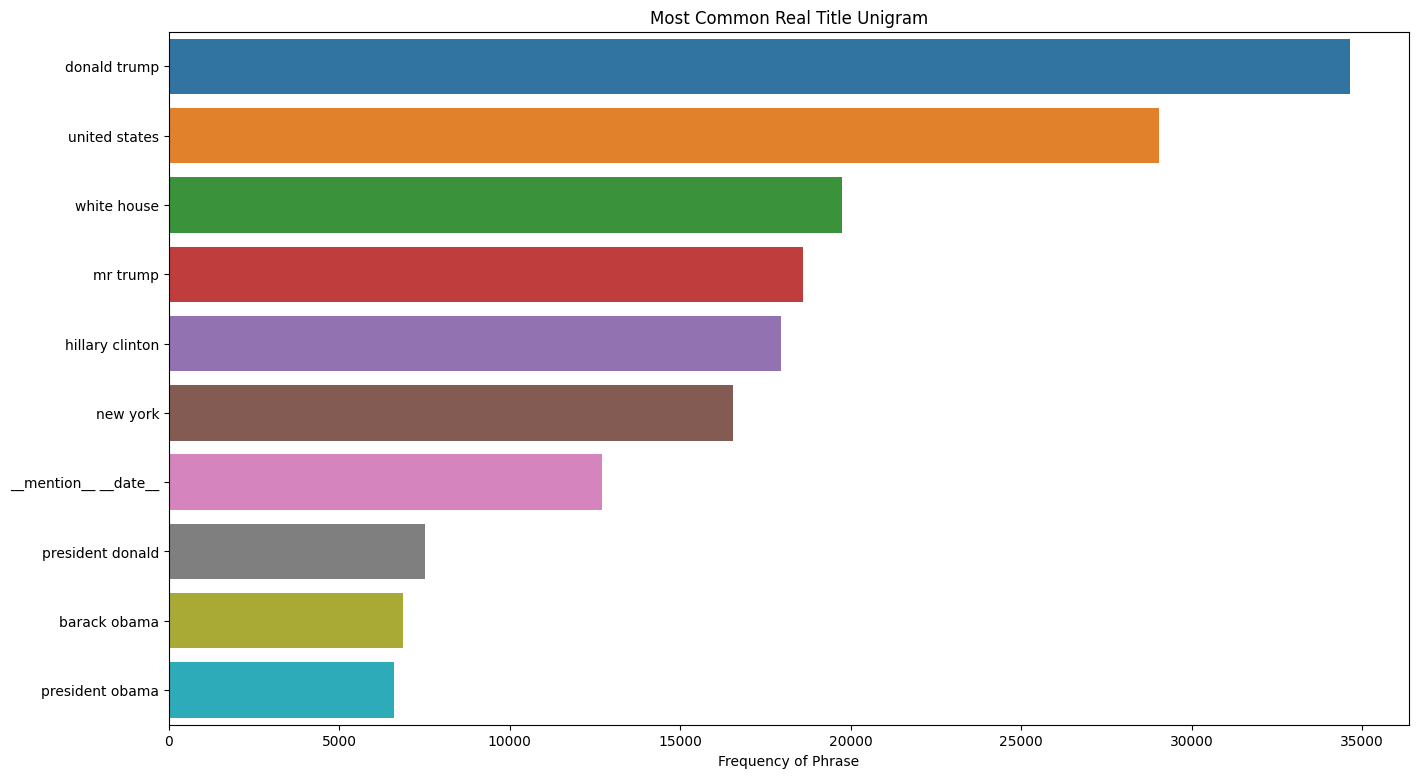

In [ ]:
plt.figure(figsize = (16,9))
most_common_bi = dict(most_common_bi)
sns.barplot(x=list(most_common_bi.values()),y=list(most_common_bi.keys()))
plt.xlabel('Frequency of Phrase')
plt.title('Most Common Real Title Unigram')

### Trigrams

In [ ]:
most_common_tri = get_top_ngrams(df_concat['clean_text'], 10, 3)

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


Text(0.5, 1.0, 'Most Common Real Title Unigram')

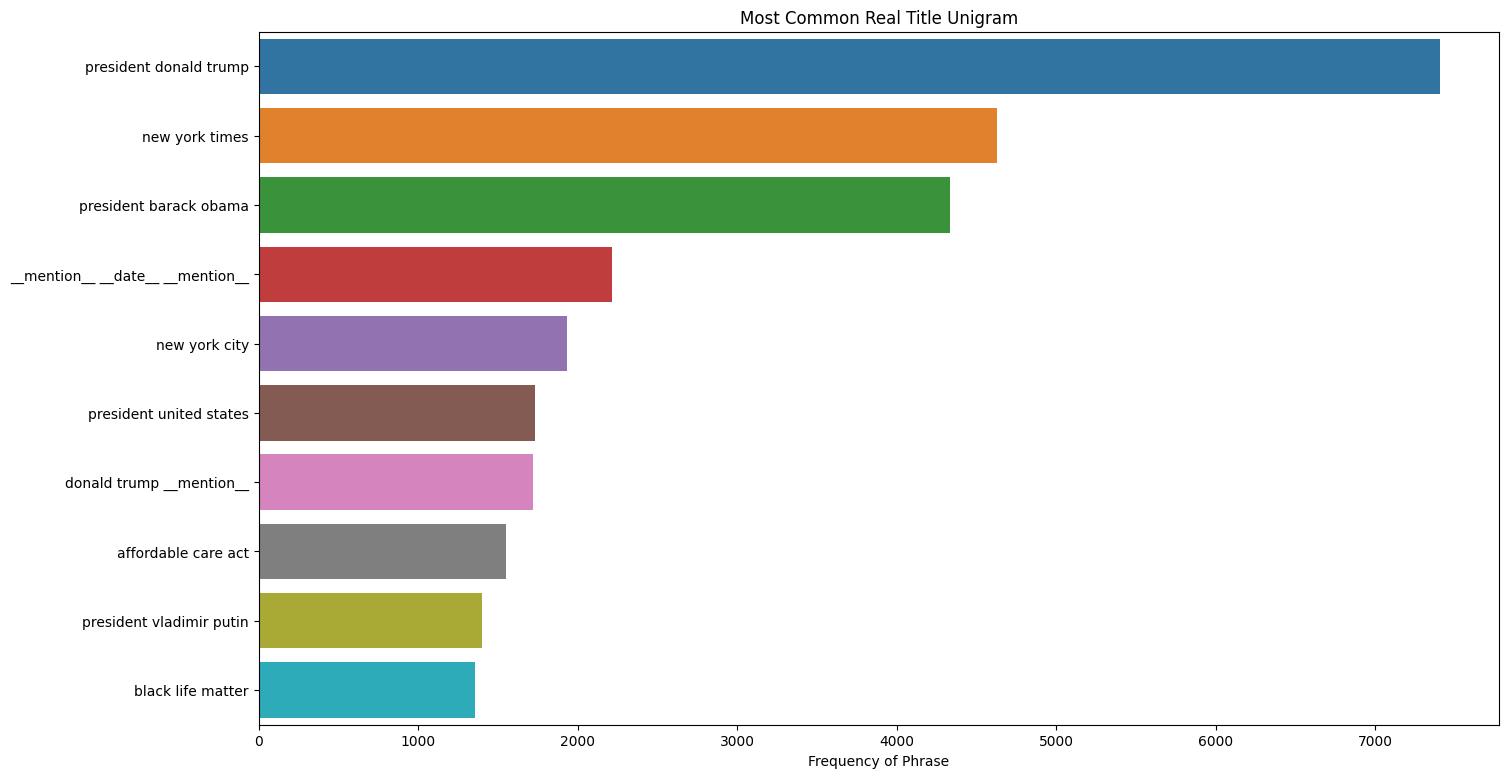

In [ ]:
plt.figure(figsize = (16,9))
most_common_tri = dict(most_common_tri)
sns.barplot(x=list(most_common_tri.values()),y=list(most_common_tri.keys()))
plt.xlabel('Frequency of Phrase')
plt.title('Most Common Real Title Unigram')

### Compare n_gram by f1 metrics in CountVectorizer + MultinomialNB

In [10]:
X = df_concat['clean_text']
y = df_concat['label']

# Split data into training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=35)

In [ ]:
for ngram in range(1, 5):
    # Convert training data to bag-of-words
    vectorizer = CountVectorizer(ngram_range=(1, ngram))
    X_train_cv = vectorizer.fit_transform(X_train)
    X_test_cv = vectorizer.transform(X_test)

    # Train with MultinomialNB: very fast
    mnb = MultinomialNB(alpha=1.0)
    mnb.fit(X_train_cv, y_train)
    y_pred = mnb.predict(X_test_cv)

    # compute f-1 score
    score = np.round(f1_score(y_test, y_pred),4)
    print('F-1 score of model with n-gram range of {}: {}'.format((1,ngram), score))

F-1 score of model with n-gram range of (1, 1): 0.8962
F-1 score of model with n-gram range of (1, 2): 0.9147
F-1 score of model with n-gram range of (1, 3): 0.9107
F-1 score of model with n-gram range of (1, 4): 0.9069


- ***The F1 scores stop increasing from the bigrams. Therefore, we should use bigram in our dataset.***

# **3. Machine Learning**

In [5]:
token_labels = df_concat[['clean_text', 'label']].sample(frac=1)

# Train, test, valid dataset split
X_train, X_test_valid, y_train, y_test_valid = train_test_split(token_labels['clean_text'], token_labels['label'], test_size=0.3, random_state=35)
X_test, X_valid, y_test, y_valid = train_test_split(X_test_valid, y_test_valid, test_size=0.5, random_state=35)

models = []
accuracy = []
f1 = []
f1_train = []

In [ ]:
def get_presentation(vectorizer, X_train, X_test, y_train, y_test):
    X_train = vectorizer.fit_transform(X_train)
    X_test = vectorizer.transform(X_test)
    return X_train, X_test, y_train, y_test

cv_rep = get_presentation(CountVectorizer(), X_train, X_test, y_train, y_test)
tf_rep = get_presentation(TfidfVectorizer(), X_train, X_test, y_train, y_test)

In [ ]:
def classify(acc, f1, f1_train, method, rep):
    X_train, X_test, y_train, y_test = rep
    pipe = make_pipeline(StandardScaler(with_mean=False), method)
    pipe.fit(X_train, y_train)
    pipe.score(X_test, y_test)
    y_pred = pipe.predict(X_test)
    acc.append(accuracy_score(y_test, y_pred))
    f1.append(f1_score(y_test, y_pred))
    f1_train.append(f1_score(y_train, pipe.predict(X_train)))
    print(classification_report(y_test, y_pred))

## Logistic Regression

### - CountVectorizer

In [ ]:
models.append("Logistic Regression with CountVectorizer")
log_reg_count = LogisticRegression(max_iter=500)
classify(accuracy, f1, f1_train, log_reg_count, cv_rep)

              precision    recall  f1-score   support

           0       0.90      0.90      0.90      5112
           1       0.90      0.90      0.90      5179

    accuracy                           0.90     10291
   macro avg       0.90      0.90      0.90     10291
weighted avg       0.90      0.90      0.90     10291



### - TfidfVectorizer

In [ ]:
models.append("Logistic Regression with TfidfVectorizer")
log_reg_tf = LogisticRegression(max_iter=500)
classify(accuracy, f1, f1_train, log_reg_tf, tf_rep)

              precision    recall  f1-score   support

           0       0.91      0.92      0.92      5112
           1       0.92      0.91      0.92      5179

    accuracy                           0.92     10291
   macro avg       0.92      0.92      0.92     10291
weighted avg       0.92      0.92      0.92     10291



## Decision Tree

#### - CountVectorizer

In [ ]:
models.append("Decision Tree with CountVectorizer")
dt_cv = DecisionTreeClassifier()
classify(accuracy, f1, f1_train, dt_cv, cv_rep)

              precision    recall  f1-score   support

           0       0.90      0.91      0.91      5112
           1       0.91      0.91      0.91      5179

    accuracy                           0.91     10291
   macro avg       0.91      0.91      0.91     10291
weighted avg       0.91      0.91      0.91     10291



#### - TfidfVectorizer

In [ ]:
models.append("Decision Tree with TfidfVectorizer")
dt_tf = DecisionTreeClassifier()
classify(accuracy, f1, f1_train, dt_tf, tf_rep)

              precision    recall  f1-score   support

           0       0.90      0.91      0.91      5112
           1       0.91      0.90      0.91      5179

    accuracy                           0.91     10291
   macro avg       0.91      0.91      0.91     10291
weighted avg       0.91      0.91      0.91     10291



In [ ]:
ml_dict = {
    'Model': models,
    'F1 train': f1_train,
    'F1': f1,
    'Accuracy': accuracy
}
report_ml_df = pd.DataFrame(ml_dict)

# 4. Deep Learning

In [ ]:
# Set hyperparameter
VOCAB_SIZE = 16000 # Coverage 95% corpus
EMBED_DIM = 40
INPUT_LEN = 1024
LOSS_METHOD = 'binary_crossentropy'
OPTIMIZER = 'adam'
METRICS = ['accuracy']
NUM_EPOCHS = 5

models = []
accuracy = []
f1 = []
f1_train = []

In [ ]:
# Fit tokenizer on X_train
tokenizer = Tokenizer(oov_token='<unk>',num_words=VOCAB_SIZE, filters=default_filters)
tokenizer.fit_on_texts(X_train)

In [ ]:
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_valid_sequences = tokenizer.texts_to_sequences(X_valid)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

X_train_padded = pad_sequences(X_train_sequences, maxlen=INPUT_LEN, truncating='post')
X_valid_padded = pad_sequences(X_valid_sequences, maxlen=INPUT_LEN, truncating='post')
X_test_padded = pad_sequences(X_test_sequences, maxlen=INPUT_LEN, truncating='post')

In [ ]:
def plot_history(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    epochs = range(1, len(loss) + 1)
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # --- Chart 1: Loss ---
    axes[0].plot(epochs, loss, 'bo-', label='Training Loss')
    axes[0].plot(epochs, val_loss, 'ro-', label='Validation Loss')
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[0].grid(True)

    # --- Chart 2: Accuracy ---
    axes[1].plot(epochs, accuracy, 'bo-', label='Training Accuracy')
    axes[1].plot(epochs, val_accuracy, 'ro-', label='Validation Accuracy')
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()

In [ ]:
def dl_predict(accuracy, f1, f1_train, model, X_train, X_test, y_train, y_test):
    y_pred = (model.predict(X_test) > 0.5).astype(int)
    y_pred_train = (model.predict(X_train) > 0.5).astype(int)
    accuracy.append(accuracy_score(y_test, y_pred))
    f1.append(f1_score(y_test, y_pred))
    f1_train.append(f1_score(y_train, y_pred_train))
    print(classification_report(y_test, y_pred, digits=4))
    return y_pred

## LSTM 50 units

In [ ]:
model = Sequential([
    Input(shape=(INPUT_LEN,)),  # InputLayer
    Embedding(input_dim=VOCAB_SIZE, output_dim=EMBED_DIM),
    LSTM(50),
    Dropout(0.5), # Dropout 50%
    Dense(1, activation='sigmoid')  # Sigmoid to classify binary label
])

model.compile(loss=LOSS_METHOD, optimizer=OPTIMIZER, metrics=METRICS)
model.summary()

W0000 00:00:1749971403.403924      35 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 1024, 40)            │         640,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 50)                  │          18,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 658,251 (2.51 MB)

 Trainable params: 658,251 (2.51 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
# train
history = model.fit(X_train_padded, y_train, validation_data=(X_valid_padded, y_valid), epochs=num_epochs, batch_size=128, callbacks=[early_stopping])

Epoch 1/5
376/376 ━━━━━━━━━━━━━━━━━━━━ 280s 736ms/step - accuracy: 0.8438 - loss: 0.3622 - val_accuracy: 0.9393 - val_loss: 0.1774
Epoch 2/5
376/376 ━━━━━━━━━━━━━━━━━━━━ 272s 724ms/step - accuracy: 0.9599 - loss: 0.1259 - val_accuracy: 0.9577 - val_loss: 0.1228
Epoch 3/5
376/376 ━━━━━━━━━━━━━━━━━━━━ 271s 720ms/step - accuracy: 0.9748 - loss: 0.0802 - val_accuracy: 0.9526 - val_loss: 0.1402
Epoch 4/5
376/376 ━━━━━━━━━━━━━━━━━━━━ 269s 715ms/step - accuracy: 0.9842 - loss: 0.0523 - val_accuracy: 0.9632 - val_loss: 0.1199
Epoch 5/5
376/376 ━━━━━━━━━━━━━━━━━━━━ 267s 709ms/step - accuracy: 0.9894 - loss: 0.0393 - val_accuracy: 0.9611 - val_loss: 0.1360


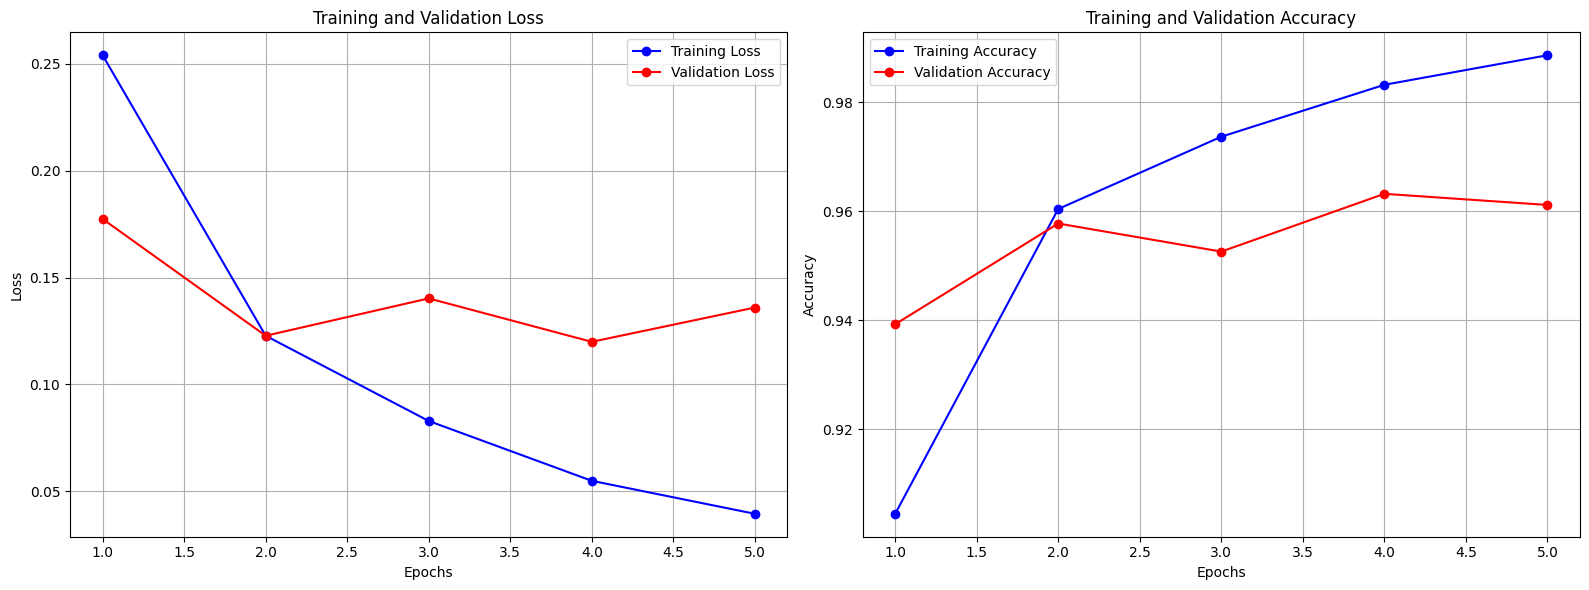

In [ ]:
plot_history(history)

In [ ]:
models.append("LSTM 50 units")
y_pred = dl_predict(accuracy, f1, f1_train, model, X_train_padded, X_test_padded, y_train, y_test)

322/322 ━━━━━━━━━━━━━━━━━━━━ 33s 102ms/step
1501/1501 ━━━━━━━━━━━━━━━━━━━━ 153s 102ms/step
              precision    recall  f1-score   support

           0     0.9510    0.9667    0.9588      5137
           1     0.9663    0.9503    0.9582      5154

    accuracy                         0.9585     10291
   macro avg     0.9586    0.9585    0.9585     10291
weighted avg     0.9586    0.9585    0.9585     10291



In [ ]:
# errors analyst
error_indices = np.where(y_pred.flatten() != y_test.values)[0]
for idx in error_indices[:30]:
    print(f"Predicted: {y_pred[idx]}, Actual: {y_test.iloc[idx]}, Length: {len(X_test.iloc[idx].split())}")
    print(f"Clean Text: {X_test.iloc[idx]}")
    print("===============================\n")

Predicted: [0], Actual: 1, Length: 80
Clean Text: medscape excerpt baltimore new finding large national claim database use cholesterol lower statin drug associate increase risk parkinson disease pd contrary previous research suggest drug protective effect pd identify parkinson disease patient look use statin associate high low risk find people use statin high risk disease opposite hypothesize senior author xuemei huang md phd vice chair research penn state college medicine hershey pennsylvania tell medscape medical news high cholesterol protective effect risk pd role statin use subject debate publish __date__

Predicted: [0], Actual: 1, Length: 291
Clean Text: shot dead chicago record deadly weekend publish zero hedge summer extreme violence homicide chicago suppose slow fall winter month certainly not appear happen city just record most violent weekend entire year people shoot kill weekend violence bring tally year date killing chicago annual run rate imply most violent year mid-90 ac

## Bi LSTM 25 units

In [ ]:
bi_model = Sequential([
    Input(shape=(INPUT_LEN,)),
    Embedding(input_dim=VOCAB_SIZE, output_dim=EMBED_DIM),
    Bidirectional(LSTM(25)),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

bi_model.compile(loss=LOSS_METHOD, optimizer=OPTIMIZER, metrics=METRICS)
bi_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (None, 1024, 40)            │         640,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 50)                  │          13,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 653,251 (2.49 MB)

 Trainable params: 653,251 (2.49 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
early_stopping_bi = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history_bi = bi_model.fit(X_train_padded, y_train, validation_data=(X_valid_padded, y_valid), epochs=num_epochs, batch_size=128, callbacks=[early_stopping_bi])

Epoch 1/5
376/376 ━━━━━━━━━━━━━━━━━━━━ 235s 612ms/step - accuracy: 0.8166 - loss: 0.4043 - val_accuracy: 0.9479 - val_loss: 0.1563
Epoch 2/5
376/376 ━━━━━━━━━━━━━━━━━━━━ 228s 606ms/step - accuracy: 0.9628 - loss: 0.1277 - val_accuracy: 0.9619 - val_loss: 0.1222
Epoch 3/5
376/376 ━━━━━━━━━━━━━━━━━━━━ 223s 593ms/step - accuracy: 0.9725 - loss: 0.0933 - val_accuracy: 0.9633 - val_loss: 0.1159
Epoch 4/5
376/376 ━━━━━━━━━━━━━━━━━━━━ 222s 589ms/step - accuracy: 0.9797 - loss: 0.0694 - val_accuracy: 0.9482 - val_loss: 0.1375
Epoch 5/5
376/376 ━━━━━━━━━━━━━━━━━━━━ 230s 612ms/step - accuracy: 0.9845 - loss: 0.0549 - val_accuracy: 0.9592 - val_loss: 0.1330


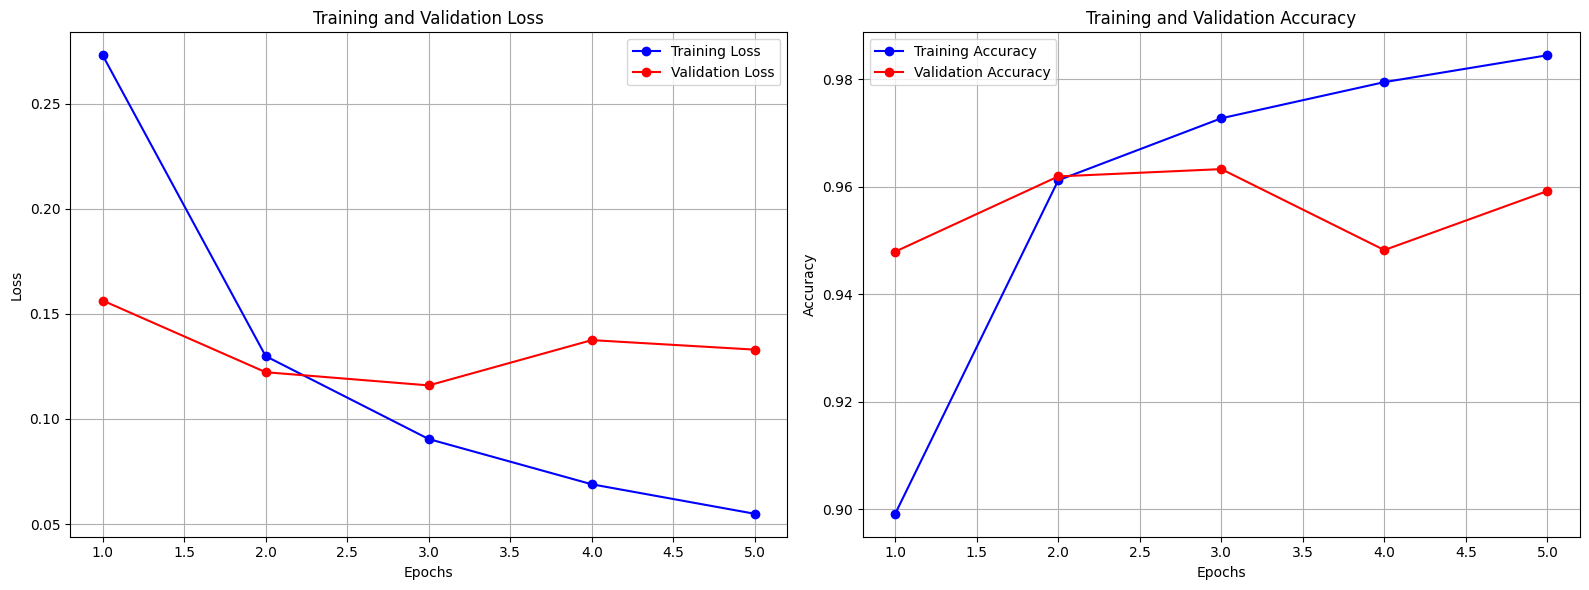

In [ ]:
plot_history(history_bi)

In [ ]:
models.append("Bi LSTM 25 units")
y_pred_bi = dl_predict(accuracy, f1, f1_train, bi_model, X_train_padded, X_test_padded, y_train, y_test)

322/322 ━━━━━━━━━━━━━━━━━━━━ 26s 81ms/step
1501/1501 ━━━━━━━━━━━━━━━━━━━━ 120s 80ms/step
              precision    recall  f1-score   support

           0     0.9544    0.9609    0.9576      5137
           1     0.9607    0.9542    0.9575      5154

    accuracy                         0.9575     10291
   macro avg     0.9576    0.9575    0.9575     10291
weighted avg     0.9576    0.9575    0.9575     10291



In [ ]:
# errors analyst
error_indices_bi = np.where(y_pred_bi.flatten() != y_test.values)[0]
for idx in error_indices_bi[:30]:
    print(f"Predicted: {y_pred_bi[idx]}, Actual: {y_test.iloc[idx]}, Length: {len(X_test.iloc[idx].split())}")
    print(f"Clean Text: {X_test.iloc[idx]}")
    print("===============================\n")

Predicted: [1], Actual: 0, Length: 35
Clean Text: end election usually come economy job wage tax import export price good cost education difference issue tax rate immigration globalization minimum wage particularly sharp year donald trump hillary clinton ’ look candidate stand economic issue

Predicted: [0], Actual: 1, Length: 80
Clean Text: medscape excerpt baltimore new finding large national claim database use cholesterol lower statin drug associate increase risk parkinson disease pd contrary previous research suggest drug protective effect pd identify parkinson disease patient look use statin associate high low risk find people use statin high risk disease opposite hypothesize senior author xuemei huang md phd vice chair research penn state college medicine hershey pennsylvania tell medscape medical news high cholesterol protective effect risk pd role statin use subject debate publish __date__

Predicted: [0], Actual: 1, Length: 291
Clean Text: shot dead chicago record deadly weeke

In [ ]:
dl_dict = {
    'Model': models,
    'F1 train': f1_train,
    'F1': f1,
    'Accuracy': accuracy
}

report_ml_df = pd.read_csv("/kaggle/input/scores-of-machine-learning-fake-news-detection/scores_report.csv")
report_dl_df = pd.DataFrame(dl_dict)
scores_report = pd.concat([report_ml_df, report_dl_df], axis=0, ignore_index=True)

## Longformer

In [6]:
tokenizer_lf = LongformerTokenizerFast.from_pretrained('allenai/longformer-base-4096')
model_lf = LongformerForSequenceClassification.from_pretrained(
    'allenai/longformer-base-4096',
    num_labels=2
)
MAX_LENGTH = 1400
LEARNING_RATE = 2e-5
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NUM_EPOCHS = 5
BATCH_SIZE = 8
WEIGHT_DECAY = 0.01
WORLD_SIZE = torch.cuda.device_count()
WORLD_SIZE

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/694 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/597M [00:00<?, ?B/s]

Some weights of LongformerForSequenceClassification were not initialized from the model checkpoint at allenai/longformer-base-4096 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


2

model.safetensors:   0%|          | 0.00/597M [00:00<?, ?B/s]

In [7]:
class CustomForward(torch.nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, **kwargs):
        output = self.model(**kwargs)
        loss = output.loss
        # patch: unsqueeze to avoid warning DataParallel gather
        if loss.dim() == 0:
            loss = loss.unsqueeze(0)
        return output.__class__(**{**output.__dict__, "loss": loss})

In [8]:
X_train_long = df_concat.iloc[X_train.index]['processed_text']
X_test_long = df_concat.iloc[X_test.index]['processed_text']
X_valid_long = df_concat.iloc[X_valid.index]['processed_text']

In [9]:
def tokenize_function(examples, max_length):
    return tokenizer_lf(examples['text'], truncation=True, padding='max_length', max_length=max_length)

tokenize_lf_fn = partial(tokenize_function, max_length=MAX_LENGTH)

train_hf_dataset = datasets.Dataset.from_pandas(pd.DataFrame({'text': X_train_long, 'labels': y_train}))
valid_hf_dataset = datasets.Dataset.from_pandas(pd.DataFrame({'text': X_valid_long, 'labels': y_valid}))

tokenized_train_dataset = train_hf_dataset.map(tokenize_lf_fn, batched=True)
tokenized_valid_dataset = valid_hf_dataset.map(tokenize_lf_fn, batched=True)

tokenized_train_dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
tokenized_valid_dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

train_dataloader = DataLoader(tokenized_train_dataset, batch_size=BATCH_SIZE)
valid_dataloader = DataLoader(tokenized_valid_dataset, batch_size=BATCH_SIZE)

Map:   0%|          | 0/48022 [00:00<?, ? examples/s]

Map:   0%|          | 0/10291 [00:00<?, ? examples/s]

In [10]:
model = CustomForward(model_lf)
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
model.to(DEVICE)
model = torch.nn.parallel.DataParallel(model)
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=len(train_dataloader)*NUM_EPOCHS
)

In [11]:
def train_model(model_lf, n_epochs, optimizer, train_dataloader, valid_dataloader, scheduler):
    for epoch in range(n_epochs):
        model_lf.train()
        train_loss = []
        all_preds = []
        all_labels = []
        postfix = {}

        print(f"---Epoch {epoch+1}---")
        loop = tqdm(train_dataloader, desc="Training")
        for batch in loop:
            batch = {k: v.to(DEVICE) for k, v in batch.items()}
            # Clear gradient
            optimizer.zero_grad()
            # Forward pass
            outputs = model_lf(**batch)
            # Get loss from outputs
            loss = outputs.loss.mean()
            # Get logits from outputs
            logits = outputs.logits
            # Backpropagation
            loss.backward()
            # Gradient clipping to avoid exploding gradients
            torch.nn.utils.clip_grad_norm_(model_lf.parameters(), max_norm=1.0)
            # Update weght
            optimizer.step()
            # Update learning rate
            scheduler.step()

            # Accumulate training loss
            train_loss.append(loss.item())
            # Get predicts from logits
            preds = torch.argmax(logits, dim=1).detach().cpu().numpy()
            # Get labels from batch
            labels = batch['labels'].cpu().numpy()

            # Extend predicts and labels to list
            all_preds.extend(preds)
            all_labels.extend(labels)

            postfix['loss'] = sum(train_loss)/len(train_loss)
            postfix['accuracy'] = accuracy_score(all_labels, all_preds)
            loop.set_postfix(**postfix)
            
        model_lf.eval()
        valid_loss = 0
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for batch in valid_dataloader:
                batch = {k: v.to(DEVICE) for k, v in batch.items()}
                outputs = model_lf(**batch)
                loss = outputs.loss.mean()
                logits = outputs.logits
                valid_loss += loss
                all_preds.append(torch.argmax(logits, dim=1).detach().cpu().numpy())
                all_labels.append(batch['labels'].cpu().numpy())
        postfix['val_loss'] = valid_loss/len(valid_dataloader)
        postfix['val_accuracy'] = accuracy_score(all_labels, all_preds)
        loop.set_postfix(**postfix)

In [ ]:
train_model(model, NUM_EPOCHS, optimizer, train_dataloader, valid_dataloader, scheduler)

---Epoch 1---


Training:   0%|          | 0/6003 [00:00<?, ?it/s]Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded to be a multiple of `config.attention_window`: 512
Training:  50%|████▉     | 2988/6003 [2:38:51<2:37:33,  3.14s/it, accuracy=0.969, loss=0.128]

# 5. Conclusion

In [ ]:
scores_report

,Model,F1 train,F1,Accuracy
0,Logistic Regression with CountVectorizer,0.999832,0.899123,0.898261
1,Logistic Regression with TfidfVectorizer,0.999958,0.916139,0.916335
2,Decision Tree with CountVectorizer,1.000000,0.909744,0.909630
3,Decision Tree with TfidfVectorizer,1.000000,0.907504,0.907298
4,LSTM 50 units,0.990929,0.958231,0.958507
5,Bi LSTM 25 units,0.985998,0.957461,0.957536


In [ ]:
scores_report.to_csv("scores_report.csv", index=False)